# Dummy example

I want to learn a function, that preserves the topology the latent space

In [1]:
import gudhi
import numpy as np
import matplotlib.pyplot as plt

from torch_topological.nn import VietorisRipsComplex, WassersteinDistance

import torch.nn as nn
import torch

from gudhi.wasserstein import wasserstein_distance
from torch.optim.lr_scheduler import LambdaLR
from sklearn.decomposition import PCA

2024-02-27 13:41:11.690980: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 13:41:11.737447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 13:41:11.737482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 13:41:11.738626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 13:41:11.746103: I tensorflow/core/platform/cpu_feature_guar

In [8]:
def wasserstein_based_loss_gudhi(features_1, features_2):
    rips = gudhi.RipsComplex(points=features_1, max_edge_length=0.5)
    rips_1 = gudhi.RipsComplex(points=features_2, max_edge_length=0.5)
    # for the first Point cloud
    st = rips.create_simplex_tree(max_dimension=2)
    st.compute_persistence()
    i = st.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)
    # for the seconds Point cloud
    st_1 = rips_1.create_simplex_tree(max_dimension=2)
    st_1.compute_persistence()
    i_1 = st_1.flag_persistence_generators()
    if len(i_1[1]) > 0:
        i1_1 = torch.tensor(i_1[1][0])
    else:
        i1_1 = torch.empty((0, 4), dtype=int)
        
    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag = torch.norm(features_1[i1[:, (0, 2)]] - features_1[i1[:, (1, 3)]], dim=-1)
    diag1 = torch.norm(features_2[i1_1[:, (0, 2)]] - features_2[i1_1[:, (1, 3)]], dim=-1)
    
    wasser = wasserstein_distance(diag, 
                                  diag1, 
                                  order=1, 
                                  enable_autodiff=True)
    return wasser


In [2]:
def wasserstein_loss(features_1, features_2, plot=False):
    vr = VietorisRipsComplex(dim=1, p=2)
    vr_2 = VietorisRipsComplex(dim=1, p=2)
    distance = WassersteinDistance(p=2, q=1)
    # for the first Point cloud
    pi_1 = vr(features_1)
    pi_2 = vr_2(features_2)
    if plot:
        plt.scatter(pi_1[0].diagram.detach().numpy()[:, 0], 
                    pi_1[0].diagram.detach().numpy()[:, 1])
        
        plt.scatter(pi_2[0].diagram.detach().numpy()[:, 0], 
                    pi_2[0].diagram.detach().numpy()[:, 1], c='r')
        
        plt.show()
        plt.close()
    wasser = distance(pi_1, pi_2)
    return wasser

In [10]:
def training_network(network, X, Z, epochs):
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    scheduler = LambdaLR(optimizer,[lambda epoch: 10./(10+epoch)])
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        view_1 = network(X)
        view_2 = network(Z)
        plot = True if epoch % 10 == 0 else False
        loss = wasserstein_loss(view_1, view_2, plot=plot)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        if epoch % 10 == 0:
            colors = np.arange(X.shape[0])
            latent_X = view_1.detach().numpy()
            latent_Y = view_2.detach().numpy()
            pca = PCA(n_components=2).fit_transform(np.concatenate([latent_X, latent_Y]))
            latent_X = pca[:len(latent_X)]
            latent_Y = pca[len(latent_X):]
            plt.scatter(latent_X[:, 0], latent_X[:, 1], c=colors, cmap='viridis')
            plt.scatter(latent_Y[:, 0], latent_Y[:, 1], c=colors, cmap='viridis', marker='x')
            plt.show()
            plt.close()
    return losses

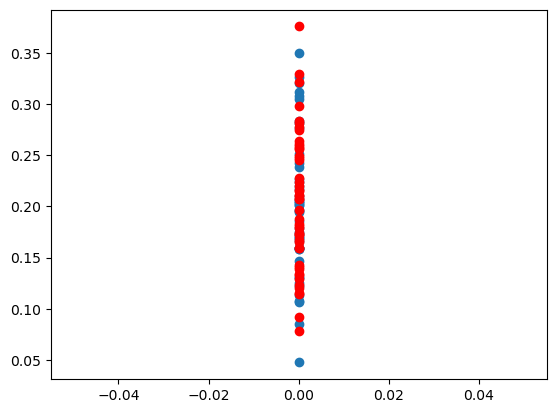

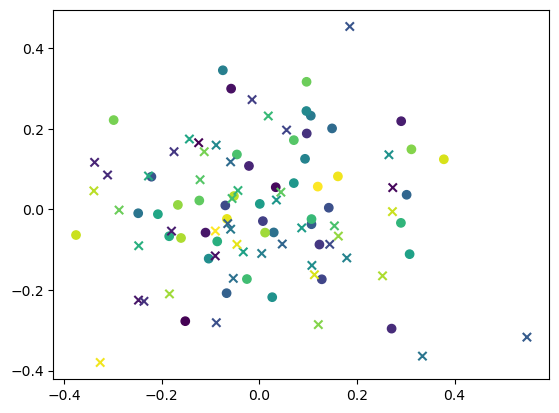

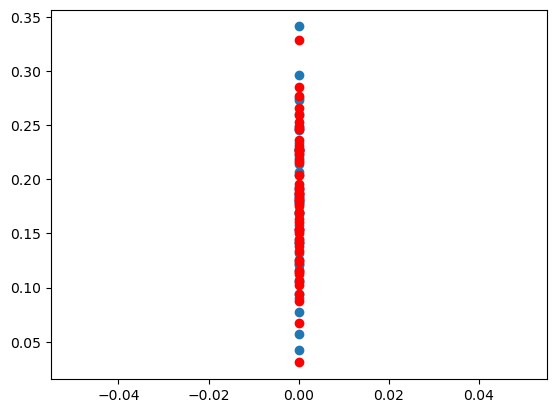

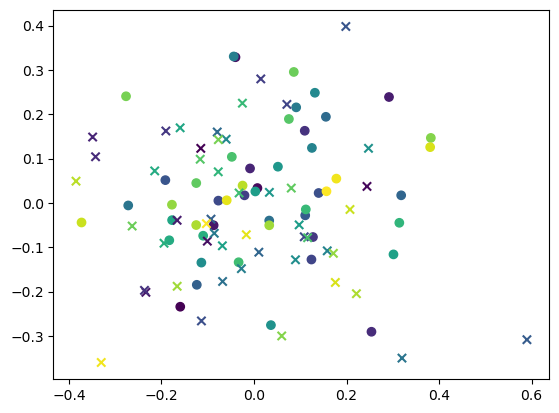

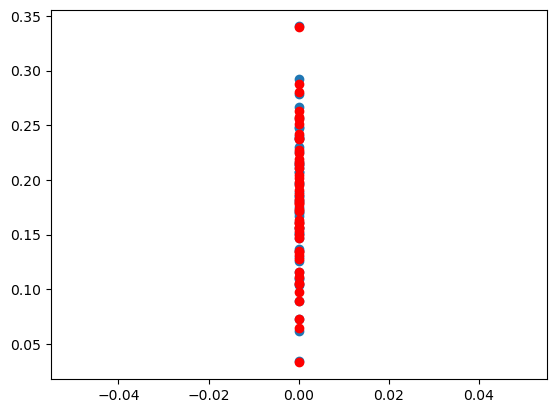

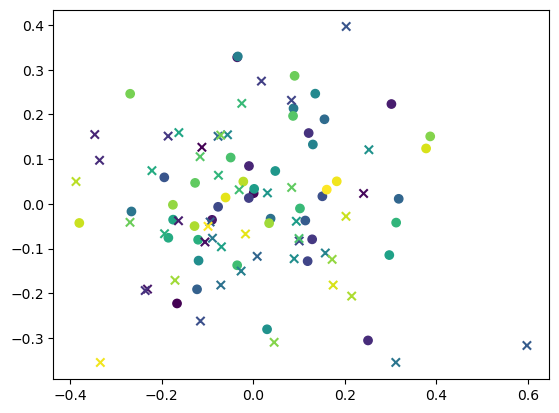

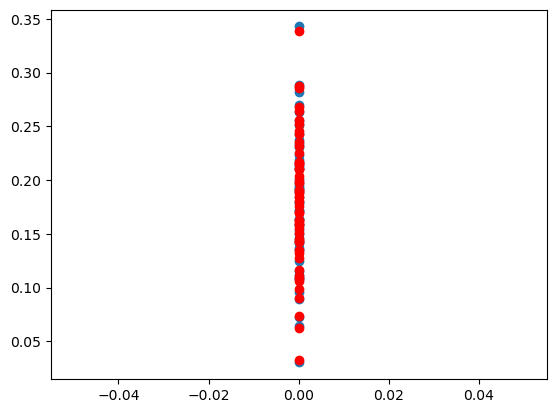

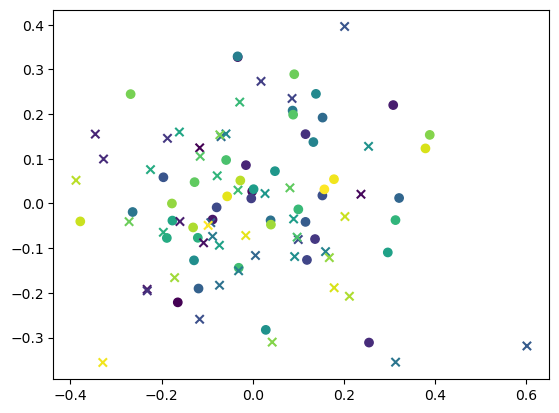

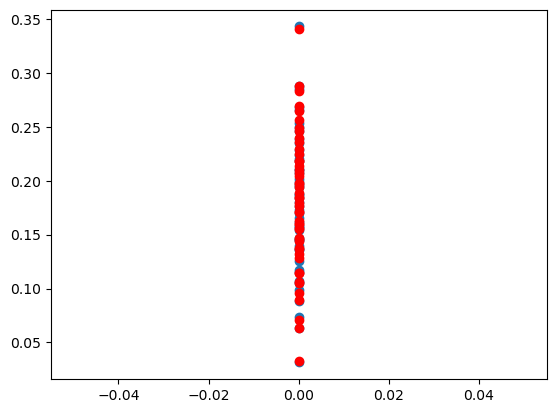

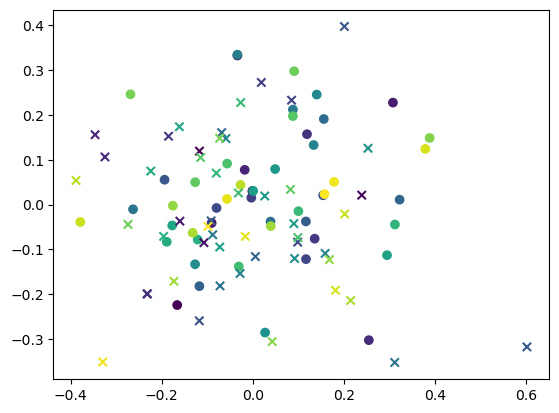

In [11]:
network = nn.Sequential(nn.Linear(200, 10),
                        nn.ReLU(),)

X = torch.tensor(np.random.rand(50, 200), dtype=torch.float32)
Y = torch.tensor(np.random.rand(50, 200), dtype=torch.float32)

losses = training_network(network, X, Y, 50)


Text(0.5, 1.0, 'Wasserstein loss on persistence diagrams in the latent space')

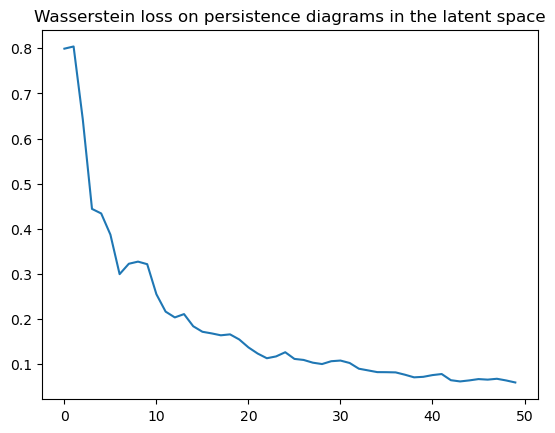

In [12]:
plt.plot(losses)
plt.title("Wasserstein loss on persistence diagrams in the latent space")